**MODEL**-CNN-BiLSTM




**OPTIMIZER**-Lazy Adam




**LEARNING RATE**-10^-4




**DROPOUT** -0.45



**LSTM LAYER**-272



**ACTIVATION**-swish




**BATCH SIZE**-96




**FILTER**-512 512



---



In [ ]:
pip install --upgrade tensorflow tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.0 MB/s eta 0:00:00


In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
pip install -q -U tensorflow-addons

In [ ]:
import time
start_time=time.time()

Import necessary libraries


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import LazyAdam
from keras.layers import Dropout

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


LOAD DATA


In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

One-hot Encoding

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# create new column weekday
train['weekday'] = np.where(train['date'].dt.dayofweek < 5, 0, 1)
test['weekday'] = np.where(test['date'].dt.dayofweek < 5, 0, 1)
# perform one-hot encoding
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

#fill sales data with 0 in test set
test['sales'] = 0


MinMax Scaling

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert the 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create weekday and weekend indicator variables based on the 'date' column
train['weekday_weekend'] = np.where(train['date'].dt.weekday < 5, 'weekday', 'weekend')

# Select columns to be scaled
val_cols = ['store', 'item']
num_cols = ['sales']

# Scale the numerical columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 200))
train[num_cols] = scaler.fit_transform(train[num_cols])

# Add the 'date', 'store', and 'item' columns back to the dataset
train = train[['date'] + val_cols + num_cols + ['weekday_weekend']]

**Train** data description


In [ ]:
print(train.describe())
print(train.head())

               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      45.238344
std         2.872283      14.430878      24.936055
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      25.974026
50%         5.500000      25.500000      40.692641
75%         8.000000      38.000000      60.606061
max        10.000000      50.000000     200.000000
        date  store  item      sales weekday_weekend
0 2013-01-01      1     1  11.255411         weekday
1 2013-01-02      1     1   9.523810         weekday
2 2013-01-03      1     1  12.121212         weekday
3 2013-01-04      1     1  11.255411         weekday
4 2013-01-05      1     1   8.658009         weekend


In [ ]:
import pandas as pd
# sort the 'date' column in each DataFrame in descending order
train = train.sort_values('date', ascending=True)
test = test.sort_values('date', ascending=True)

# extract the latest date from each DataFrame
train_last_date = train.iloc[-1]['date']
test_last_date = test.iloc[-1]['date']

# convert latest dates to datetime objects and format them as strings
train_last_date = pd.to_datetime(train_last_date).strftime('%Y-%m-%d')
test_last_date = pd.to_datetime(test_last_date).strftime('%Y-%m-%d')

In [ ]:
# Print minimum and maximum date of train set
print("Train set date range: {} to {}".format(train['date'].min(), train['date'].max()))

# Print minimum and maximum date of test set
print("Test set date range: {} to {}".format(test['date'].min(), test['date'].max()))

Train set date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Test set date range: 2018-01-01 00:00:00 to 2018-03-31 00:00:00


In [ ]:
# print the latest dates and the number of days between them
print("Train last date:", train_last_date)
print("Test last date:", test_last_date)
lag_size = (pd.to_datetime(test_last_date) - pd.to_datetime(train_last_date)).days
print("Number of days between train and test last dates:", lag_size)


Train last date: 2017-12-31
Test last date: 2018-03-31
Number of days between train and test last dates: 90


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
fig = go.Figure(data=[daily_sales_sc],layout=layout)
fig.show(renderer="colab")

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

Reduce training set with the last year alone

In [ ]:
train = train[(train['date'] >= '2017-01-01')]
print(train.head())

             date  store  item      sales weekday_weekend
481699 2017-01-01      4    27  15.584416         weekend
695341 2017-01-01      1    39  31.168831         weekend
823161 2017-01-01      1    46  32.900433         weekend
523697 2017-01-01      7    29  37.229437         weekend
636909 2017-01-01      9    35  57.142857         weekend


Rearrange datasets to apply shift methods


In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,16.450216
1,1,1,2017-01-02,12.987013
2,1,1,2017-01-03,8.658009
3,1,1,2017-01-04,13.852814
4,1,1,2017-01-05,12.121212


Conversion of pandas data into supervised data

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

forecast 90 days with current timesteps


In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,16.450216,1.0,1.0,12.987013,1.0,1.0,8.658009,1.0,...,13.852814,1.0,1.0,20.779221,1,1,7.792208,1.0,1.0,28.571429
30,1.0,1.0,12.987013,1.0,1.0,8.658009,1.0,1.0,13.852814,1.0,...,20.779221,1.0,1.0,7.792208,1,1,14.718615,1.0,1.0,12.987013
31,1.0,1.0,8.658009,1.0,1.0,13.852814,1.0,1.0,12.121212,1.0,...,7.792208,1.0,1.0,14.718615,1,1,12.987013,1.0,1.0,18.181818
32,1.0,1.0,13.852814,1.0,1.0,12.121212,1.0,1.0,20.779221,1.0,...,14.718615,1.0,1.0,12.987013,1,1,14.718615,1.0,1.0,25.108225
33,1.0,1.0,12.121212,1.0,1.0,20.779221,1.0,1.0,12.121212,1.0,...,12.987013,1.0,1.0,14.718615,1,1,20.779221,1.0,1.0,16.450216


drop items other than the shifted

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns


In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

train validation split

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,83.982684,96.103896,77.922078,99.567100,106.493506,60.606061,85.714286,64.069264,92.640693,93.506494,...,73.593074,82.251082,106.493506,94.372294,109.956710,114.285714,75.324675,87.445887,88.311688,98.701299
160385,32.900433,37.229437,37.229437,47.619048,40.692641,44.155844,32.900433,35.497835,32.034632,51.082251,...,35.497835,32.900433,32.900433,45.887446,45.887446,38.961039,38.095238,20.779221,25.974026,32.034632
73123,47.619048,38.961039,35.497835,39.826840,40.692641,31.168831,25.974026,39.826840,35.497835,36.363636,...,32.900433,31.168831,34.632035,43.290043,38.095238,38.095238,34.632035,32.900433,43.290043,42.424242
90428,120.346320,135.930736,73.593074,85.714286,117.748918,95.238095,104.761905,106.493506,127.272727,78.787879,...,112.554113,110.822511,110.822511,82.251082,100.432900,95.238095,101.298701,102.164502,111.688312,114.285714
167151,74.458874,50.216450,76.190476,75.324675,98.701299,97.835498,55.411255,65.800866,75.324675,70.129870,...,47.619048,57.142857,51.082251,45.887446,54.545455,51.082251,66.666667,33.766234,48.484848,53.679654


In [ ]:
from keras import optimizers
epochs = 200
batch = 96
lr = 0.0001

For CNN parameters(samples,timesteps,features)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [ ]:

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=512, kernel_size=2, activation='swish', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='swish'))
model_cnn.add(Dropout(0.45))
model_cnn.add(Dense(1))
from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_cnn.compile(loss='mse', optimizer=opt)
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 29, 512)           1536      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 512)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7168)              0         
                                                                 
 dense_7 (Dense)             (None, 50)                358450    
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                      

BiLstm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(272, activation='swish'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_bilstm.add(Dense(1))
model_bilstm.add(Dropout(0.45))
from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_bilstm.compile(loss='mse', optimizer=opt)
model_bilstm.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 544)              596224    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 545       
                                                                 
 dropout_6 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 596,769
Trainable params: 596,769
Non-trainable params: 0
_________________________________________________________________


CNN-BiLSTM [sample,subsequences,timesteps,features]

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, LSTM, Dense

model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=512, kernel_size=1, activation='swish'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_bilstm.add(TimeDistributed(Flatten()))
model_cnn_bilstm.add(Bidirectional(LSTM(272, activation='swish')))
model_cnn_bilstm.add(Dropout(0.45))
model_cnn_bilstm.add(Dense(1))
model_cnn_bilstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())
model_cnn_bilstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 15, 512)    1024      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 7, 512)     0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 3584)       0         
 tributed)                                                       
                                                                 
 bidirectional_4 (Bidirectio  (None, 544)              8392832   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 544)              

In [ ]:
cnn_bilstm_history = model_cnn_bilstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/200
3149/3149 - 56s - loss: 372.9855 - val_loss: 303.2158 - 56s/epoch - 18ms/step
Epoch 2/200
3149/3149 - 54s - loss: 338.2521 - val_loss: 275.5706 - 54s/epoch - 17ms/step
Epoch 3/200
3149/3149 - 53s - loss: 323.0672 - val_loss: 275.9759 - 53s/epoch - 17ms/step
Epoch 4/200
3149/3149 - 58s - loss: 317.5948 - val_loss: 294.7185 - 58s/epoch - 18ms/step
Epoch 5/200
3149/3149 - 59s - loss: 318.7934 - val_loss: 269.8593 - 59s/epoch - 19ms/step
Epoch 6/200
3149/3149 - 53s - loss: 314.9660 - val_loss: 273.0807 - 53s/epoch - 17ms/step
Epoch 7/200
3149/3149 - 58s - loss: 312.1203 - val_loss: 284.3099 - 58s/epoch - 18ms/step
Epoch 8/200
3149/3149 - 53s - loss: 309.2262 - val_loss: 271.3182 - 53s/epoch - 17ms/step
Epoch 9/200
3149/3149 - 58s - loss: 309.0074 - val_loss: 267.8813 - 58s/epoch - 18ms/step
Epoch 10/200
3149/3149 - 52s - loss: 304.6241 - val_loss: 267.8309 - 52s/epoch - 17ms/step
Epoch 11/200
3149/3149 - 53s - loss: 305.2460 - val_loss: 268.3499 - 53s/epoch - 17ms/step
Epoch 12

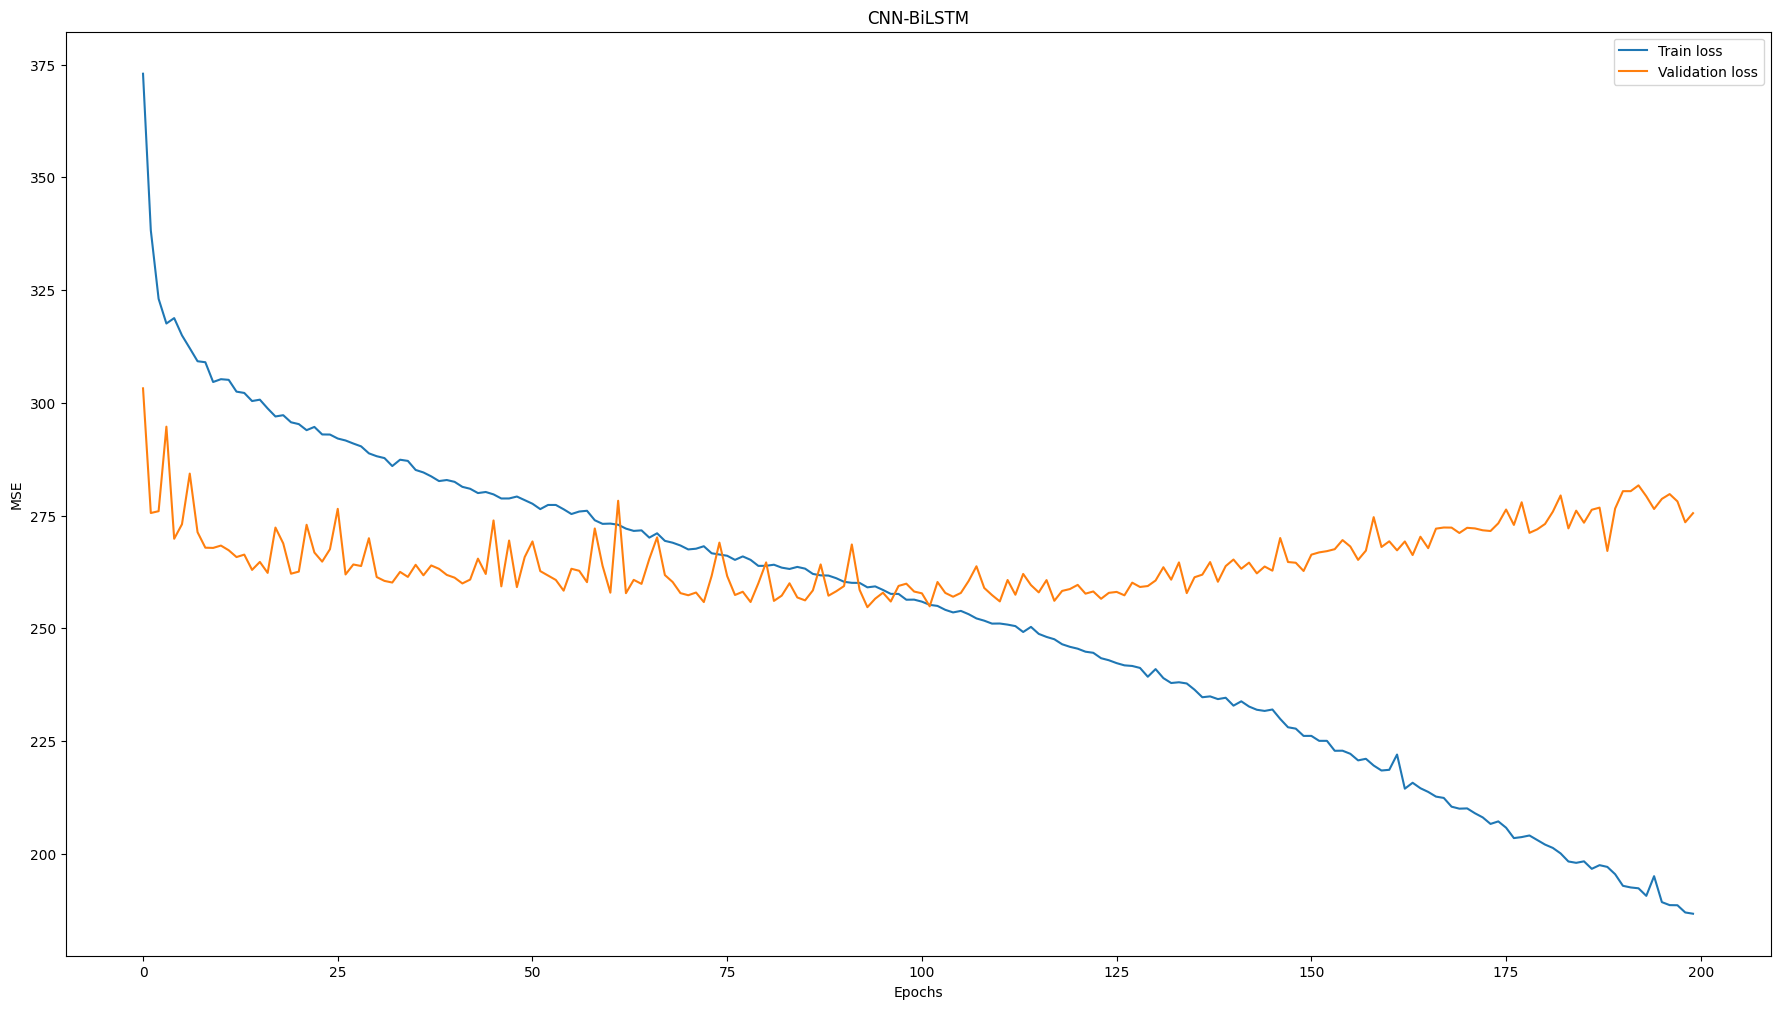

In [ ]:
fig, ax4 = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(22,12))

ax4.plot(cnn_bilstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_bilstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-BiLSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
cnn_bilstm_train_pred = model_cnn_bilstm.predict(X_train_series_sub)
cnn_bilstm_valid_pred = model_cnn_bilstm.predict(X_valid_series_sub)
end_time=time.time()

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_bilstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_bilstm_valid_pred)))

2099/2099 [==============================] - 6s 3ms/step
Train rmse: 12.825140171935423
Validation rmse: 16.59930892042519


Calculating Performance measures

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(Y_train, cnn_bilstm_train_pred)
mape = mean_absolute_percentage_error(Y_train, cnn_bilstm_train_pred) * 100
r2 = r2_score(Y_train, cnn_bilstm_train_pred)
execution_time=end_time-start_time

# Print the results
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.2f}%".format(mape))
print("R-squared: {:.4f}".format(r2))
print("Execution time",execution_time)

MAE: 9.6756
MAPE: 25.30%
R-squared: 0.7806
Execution time 11157.774100542068
